# Vivendo - Fast Food Claims

Author - Matheus Alexandre de Araujo
matheusalexandre.engcomp@gmail.com



## Background

Vivendo is a fast food chain in Brazil with over 200 outlets.
Customers often claim compensation from the company for food poisoning.
The legal team processes these claims. The legal team has offices in four locations.
The legal team wants to improve how long it takes to reply to customers and close claims.
The head of the legal department wants **a report on how each location differs in the time it
takes to close claims**.

In general, there are two possible reasons as to why the claims are taking longer than they should:

1 - There is a problem with the claims themselves;

2 - There is a problem with the process to close claims, maybe the fast food chain is doing something wrong or a specific team is being an underperformer;

Of course, we should still be keeping an eye out for unusual behavior, but we should remember to check trends among claims or among teams.

I'll be working with Python to do data analysis and with Seaborn to do data visualizations.
First, I'll import all the necessary libraries, add the .csv file as a Pandas DataFrame and call _.head()_ to check if the file has been succesfully imported.

In [1]:
#@title
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#@title
food_claims_df = pd.read_csv("https://raw.githubusercontent.com/matheusaraujotrd/Projetos-Data-Science/main/Case-Study-1-Food-Claims/food_claims_2212.csv", index_col="claim_id")
food_claims_df.head(5)

,time_to_close,claim_amount,amount_paid,location,individuals_on_claim,linked_cases,cause
claim_id,,,,,,,
1,317,R$ 74474.55,51231.37,RECIFE,15,False,unknown
2,195,R$ 52137.83,42111.30,FORTALEZA,12,True,unknown
3,183,R$ 24447.2,23986.30,SAO LUIS,10,True,meat
4,186,R$ 29006.28,27942.72,FORTALEZA,11,False,meat
5,138,R$ 19520.6,16251.06,RECIFE,11,False,vegetable


## Part I - Data Cleansing



First step after loading required libraries and the desired DataFrame: checking variables from DataFrame to see whether they match (or not) their description

In [3]:
#@title
food_claims_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time_to_close         2000 non-null   int64  
 1   claim_amount          2000 non-null   object 
 2   amount_paid           1964 non-null   float64
 3   location              2000 non-null   object 
 4   individuals_on_claim  2000 non-null   int64  
 5   linked_cases          1974 non-null   object 
 6   cause                 2000 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 125.0+ KB


Since there are 2000 entries, I know that the *amount_paid* and *linked_cases* have 36 and 26 missing values, respectively.

By checking the *.head()* call in In[2], I noticed that _claim_amount_ is stored as a string, since there are the extra characters "R$ ". They could really make a mess with our data, so that's why I should remove those special characters:

In [4]:
#@title
to_replace = ["R", "$", " "]
for item in to_replace:
    food_claims_df["claim_amount"] = food_claims_df.claim_amount.str.replace(item, '', regex=False)
food_claims_df.head(2)

,time_to_close,claim_amount,amount_paid,location,individuals_on_claim,linked_cases,cause
claim_id,,,,,,,
1,317,74474.55,51231.37,RECIFE,15,False,unknown
2,195,52137.83,42111.30,FORTALEZA,12,True,unknown


Now we are able to convert _claim_amount_ to float:

In [5]:
#@title
food_claims_df["claim_amount"] = food_claims_df["claim_amount"].astype(float)
food_claims_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time_to_close         2000 non-null   int64  
 1   claim_amount          2000 non-null   float64
 2   amount_paid           1964 non-null   float64
 3   location              2000 non-null   object 
 4   individuals_on_claim  2000 non-null   int64  
 5   linked_cases          1974 non-null   object 
 6   cause                 2000 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 125.0+ KB


In [6]:
#@title
food_claims_df["cause"].unique()

array(['unknown', 'meat', 'vegetable', ' Meat', 'VEGETABLES'],
      dtype=object)

We have a few duplicate categories here, so we should standardized them.

In [7]:
#@title
to_replace = [" ", "M", "VEGETABLES"]
food_claims_df["cause"] = food_claims_df["cause"].str.replace(to_replace[0], "")
food_claims_df["cause"] = food_claims_df["cause"].str.replace(to_replace[1], "m")
food_claims_df["cause"] = food_claims_df["cause"].str.replace(to_replace[2], to_replace[2].lower())
food_claims_df["cause"] = food_claims_df["cause"].str.replace("s", "")
food_claims_df["cause"].unique()

array(['unknown', 'meat', 'vegetable'], dtype=object)

Next, we'll cast location and cause as categories. We'll also convert linked_cases to Bool.

In [8]:
#@title
for item in ["location", "cause"]:
    food_claims_df[item] = food_claims_df[item].astype("category")
food_claims_df["linked_cases"] = food_claims_df["linked_cases"].astype(bool)
food_claims_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   time_to_close         2000 non-null   int64   
 1   claim_amount          2000 non-null   float64 
 2   amount_paid           1964 non-null   float64 
 3   location              2000 non-null   category
 4   individuals_on_claim  2000 non-null   int64   
 5   linked_cases          2000 non-null   bool    
 6   cause                 2000 non-null   category
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 84.3 KB


Now the only thing left is to fill null values of _amount_paid_ with overall median amount and _linked_cases_ with False.

In [9]:
#@title
food_claims_cleaned = food_claims_df
amount_paid_median = round(food_claims_cleaned["amount_paid"].median(), 2)
food_claims_cleaned["amount_paid"].fillna(amount_paid_median, inplace=True)
food_claims_cleaned["linked_cases"].fillna(False, inplace=True)
food_claims_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   time_to_close         2000 non-null   int64   
 1   claim_amount          2000 non-null   float64 
 2   amount_paid           2000 non-null   float64 
 3   location              2000 non-null   category
 4   individuals_on_claim  2000 non-null   int64   
 5   linked_cases          2000 non-null   bool    
 6   cause                 2000 non-null   category
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 84.3 KB


### Summarizing the Data Cleansing Process for Each Variable:

* _claim_id_ - It is our DataFrame index, so there can't be any missing or duplicate values. It is working as intended (it matches the data description).
* _time_to_close_ - The data is indeed discrete (integer). There are no missing values and by checking data with _.head()_ or _.unique() _calls I didn't find anything unusual.
* _claim_amount_ - Originally didn't matched the description. It was stored as an object, so it had string-like behaviors, including extra characters ("R$ "). I *removed* the extra characters and converted the data to float type. After that, this column matches the description.
* _amount_paid_ - This column had the correct data type (float/continuous), but it had 36 missing values. I replaced missing values with overall median from column _amount_paid_, rounded to 2 decimal points.
* _location_ - No missing data, the column had an expected data type. The only thing I did was convert it from an object type to a category type to make analysis easier.
* _individuals_on_claim_ - No missing values and data type matches description (discrete/integer). I didn't find anything wrong with that column.
* _linked_cases_ - Boolean data. This column had 26 missing values, so I replaced them with False value. I converted this data to bool just to make analysis easier once again.
* _cause_ - A few duplicate categories. There were no missing data and the data type matched the description. I standardized the categories One more time, I converted this column to category type in order to make analysis easier to visualize and manipulate.

## Part II - First Data **Visualizations**

We'll start checking the relationship between number of claims and each office location.

To do this, We'll check every available location and then plot a countplot to check how many processed claims every office has.

In [10]:
#@title
food_claims_cleaned["location"].cat.categories

Index(['FORTALEZA', 'NATAL', 'RECIFE', 'SAO LUIS'], dtype='object')

[Text(0.5, 1.0, 'Total Claims By Location'),
 Text(0.5, 0, 'Claims'),
 Text(0, 0.5, 'Offices')]

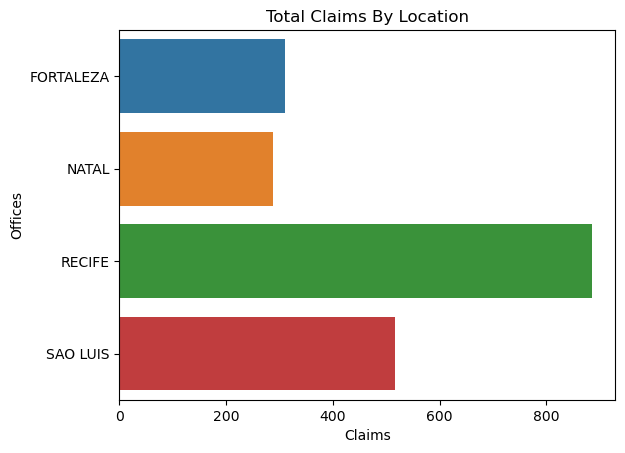

In [11]:
#@title
sns.countplot(data=food_claims_cleaned, y="location").set(title="Total Claims By Location", xlabel="Claims", ylabel="Offices")

**Recife** has **much** more **observations** than the rest of the offices and more than double the number of observations from Fortaleza and Natal. Since it has more than double the observations from Fortaleza and Natal, we are able to say that the **observations aren't well distributed between offices**. This might be a problem for our sample, **adding** a **degree of uncertainty**.

## Part III - Time Distribution

Next, we'll check the time (*time_to_close*, which calculates time by days) distribution of those claims.

We'll start by plotting a histogram for "Time to close" variable with _binwidth = 10..._

[Text(0.5, 1.0, 'Days to Close Claims'),
 Text(0.5, 0, 'Days'),
 Text(0, 0.5, 'Frequency')]

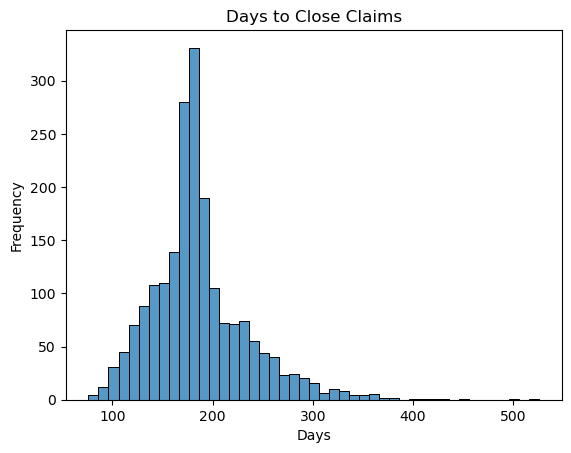

In [12]:
#@title
sns.histplot(data=food_claims_cleaned, x="time_to_close", binwidth=10).set(title="Days to Close Claims", xlabel="Days", ylabel="Frequency")

The plot above shows a slight right-skewed distribution, even though it might resemble a normal distribution (Bell curve).

In [13]:
#@title
food_claims_cleaned["time_to_close"].describe()

count    2000.00000
mean      185.56800
std        49.16339
min        76.00000
25%       158.00000
50%       179.00000
75%       204.00000
max       518.00000
Name: time_to_close, dtype: float64

Further analysing data regarding the distribution of "time_to_close", we see that is has **mean** 185.7, **median** 179, a **min** of 76.0 and a **max** of 518.
The describe method along with the plot provides great insight regarding the time to close distribution.

This right-skewed distribution shows that the data has a trend of lower-numbers, where the biggest probability is on the left tail. **This might be proof that the claims taking too long to be closed might not be a problem of the claims themselves, since most of them are on the lower end of the distribution.**

## Part IV - Time x Team Relationship

Finally, we are going to analyze the behavior between the time (time_to_close) and the different legal teams (location).

To better describe this relationship, we'll start by plotting boxplots for each location:

[Text(0.5, 1.0, 'Days to Close x Location'),
 Text(0.5, 0, 'Location'),
 Text(0, 0.5, 'Days to Close')]

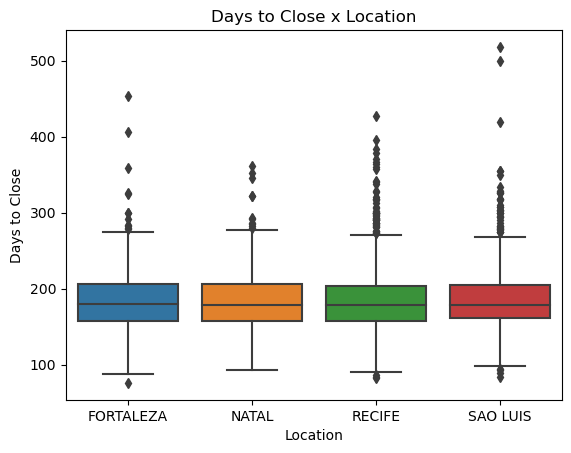

In [14]:
#@title
sns.boxplot(data=food_claims_cleaned, x="location", y="time_to_close").set(title="Days to Close x Location", xlabel="Location", ylabel="Days to Close")

This shows us some interesting info. In general, most of the claims are closed at around ~160-200 days, with **São Luis having a slight higher distribution**. Calculating Q1 and Q3 will give us the specific values:

In [15]:
#@title
q1 = np.quantile(food_claims_cleaned["time_to_close"], 0.25)
q3 = np.quantile(food_claims_cleaned["time_to_close"], 0.75)
display(q1, q3)

158.0

204.0

This confirms that, in general, most claims are closed between 158 and 204 days. São Luis has the biggest (slower) distribution, with outliers with more than 500 days until closed. This number of outliers shows us that we have a lot of extreme values in this dataset. Since we can't confirm they are any kind of error, they shouldn't be removed, or we could be removing important data.

Now, we shall create a dataframe with the fastest claims closed and plot it as a bar:

In [16]:
#@title
fastests_claims = food_claims_cleaned[food_claims_cleaned["time_to_close"] <= q1]

[Text(0.5, 1.0, 'Fastests Claims by Location'),
 Text(0.5, 0, 'Location'),
 Text(0, 0.5, 'Number of claims')]

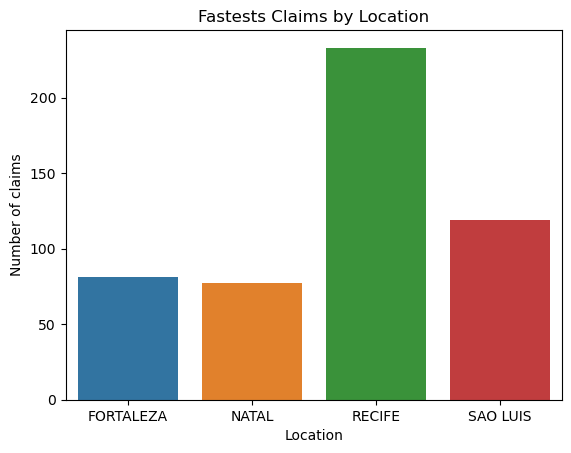

In [17]:
#@title
sns.countplot(data=fastests_claims, x="location").set(title="Fastests Claims by Location", xlabel="Location", ylabel="Number of claims")

[Text(0.5, 1.0, 'Slowest Claims by Location'),
 Text(0.5, 0, 'Location'),
 Text(0, 0.5, 'Number of claims')]

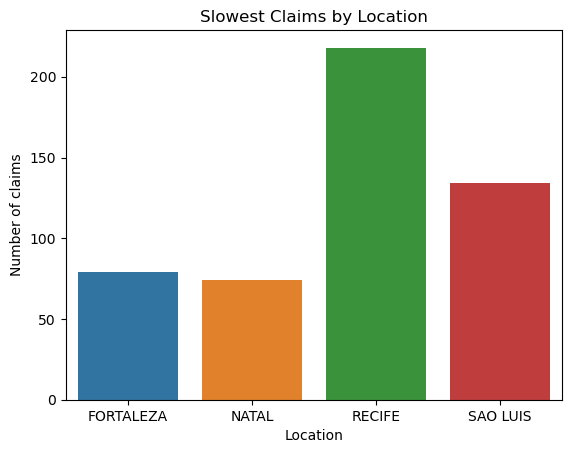

In [18]:
#@title
slowest_claims = food_claims_cleaned[food_claims_cleaned["time_to_close"] >= q3]
sns.countplot(data=slowest_claims, x="location").set(title="Slowest Claims by Location", xlabel="Location", ylabel="Number of claims")

The proportion of fastest and slowest claims are the same, so right now we **can't confirm** if there is an office more or less efficient than the others.

<AxesSubplot:xlabel='location', ylabel='count'>

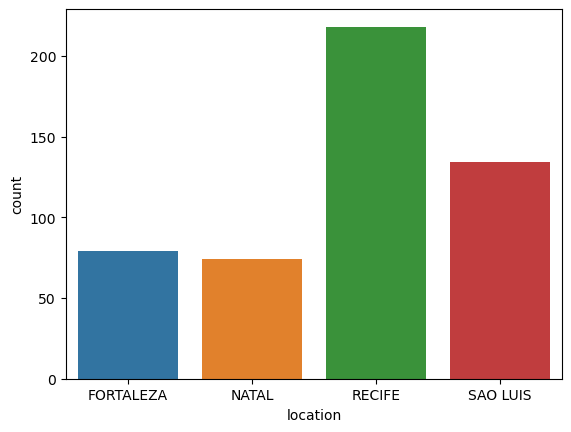

In [19]:
#@title
sns.countplot(data=slowest_claims, x="location")

## Part IV - Other Correlations

Plotting a heatmap, we get the following:

[Text(0.5, 1.0, 'Correlation Among Dataset')]

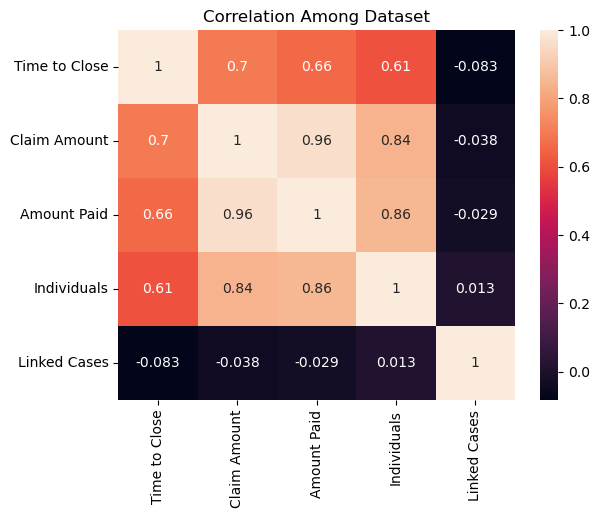

In [20]:
#@title
labels = ["Time to Close", "Claim Amount", "Amount Paid", "Individuals", "Linked Cases"]
sns.heatmap(data=food_claims_cleaned.corr(numeric_only=True), annot=True, xticklabels = labels, yticklabels = labels).set(title="Correlation Among Dataset")

This shows us some interesting data. linked_cases as strongly negatively related to time_to_close; amount_paid as strongly positively related to claim_amount (which is to be expected); and claim_amount somewhat positively related to time_to_close. Let's plot some linear regression plots:

[Text(0.5, 1.0, 'Time to Close x Amount Paid'),
 Text(0.5, 0, 'Amount Paid'),
 Text(0, 0.5, 'Time to Close'),
 [Text(0, 0, '0'),
  Text(10000, 0, '10k'),
  Text(20000, 0, '20k'),
  Text(30000, 0, '30k'),
  Text(40000, 0, '40k'),
  Text(50000, 0, '50k')]]

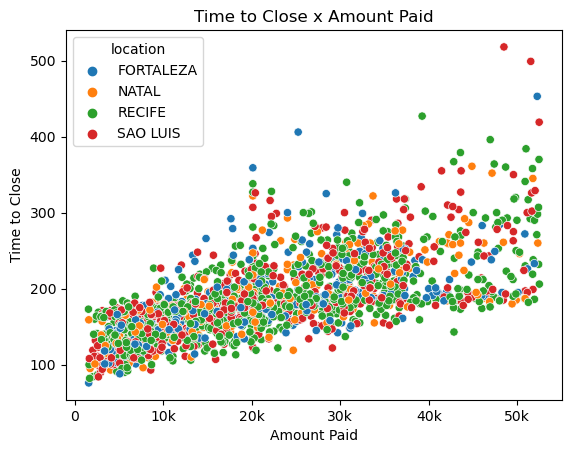

In [21]:
#@title
sns.scatterplot(data=food_claims_cleaned, y="time_to_close", x="amount_paid", hue="location").set(title="Time to Close x Amount Paid", xlabel="Amount Paid", ylabel="Time to Close", xticks=([0, 10000, 20000, 30000, 40000, 50000]), xticklabels=(["0", "10k", "20k", "30k", "40k", "50k"]))


Indeed. specially at the lower leverls (0-~30000), claims with less amounts seems to be processed faster. But again, this represents majority of cases, so it is not as reliable as it may seem.

Now, to check another probable correlation presented in the heatmap, *time_to_close* and *individuals_on_claim:*

Here, we'll plot individuals distribution for the whole dataset, for the fastest claims and for the slowest claims:

[Text(0.5, 1.0, 'Individuals Distribution on Fastest Claims'),
 Text(0.5, 0, 'Individuals')]

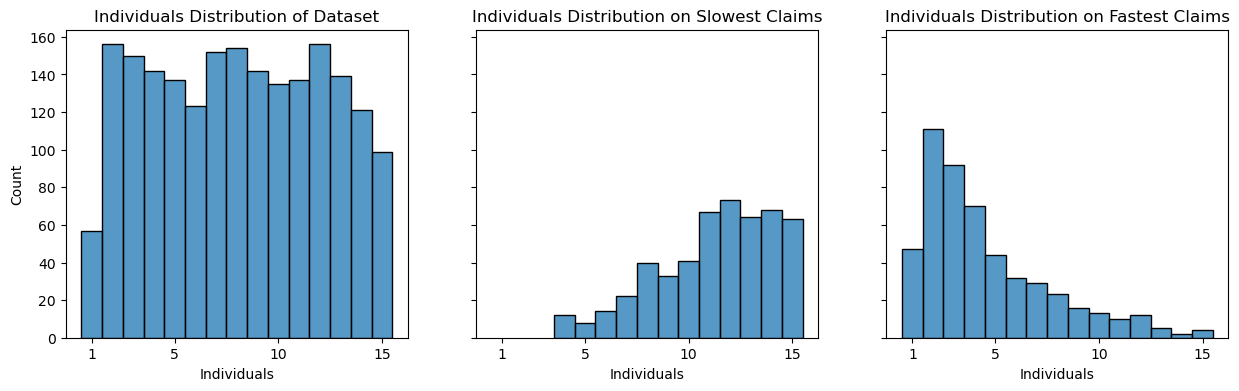

In [22]:
#@title
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True, sharex=True)
sns.histplot(ax=axes[0], data=food_claims_cleaned, x="individuals_on_claim", discrete=True).set(title="Individuals Distribution of Dataset", xlabel="Individuals", xticks=([1, 5,10,15]), xticklabels=(["1", "5", "10", "15"]))
sns.histplot(ax=axes[1], data=slowest_claims, x="individuals_on_claim", discrete=True).set(title="Individuals Distribution on Slowest Claims", xlabel="Individuals")
sns.histplot(ax=axes[2], data=fastests_claims, x="individuals_on_claim", discrete=True).set(title="Individuals Distribution on Fastest Claims", xlabel="Individuals")

* **Dataset:** A bit of skewing here and there, but almost a uniform distribution.

* **Slowest Claims:** Clearly a left-skewed distribution. So slowest claims seems to have more individuals.

* **Fastest Claims:** Now we have a right-skewed distribution: fastest claims with fewer number of individuals.

After checking the individuals distribution between claims, let's check the individuals distribution between locations:

[Text(0.5, 1.0, 'Fortaleza Individuals Per Claim'),
 Text(0.5, 0, 'Individuals'),
 [Text(1, 0, '1'), Text(5, 0, '5'), Text(10, 0, '10'), Text(15, 0, '15')]]

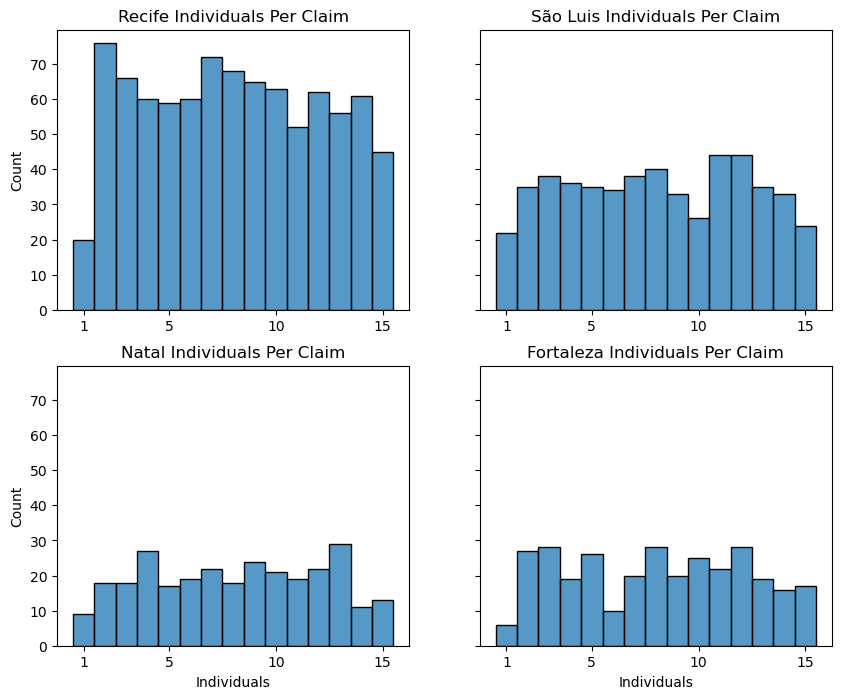

In [23]:
#@title
fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharey = True)
sns.histplot(ax = ax[0, 0], data=food_claims_cleaned[food_claims_cleaned["location"] == "RECIFE"], x="individuals_on_claim", discrete=True).set(title="Recife Individuals Per Claim", ylabel="Count", xticks=([1, 5,10,15]), xticklabels=(["1", "5", "10", "15"]), xlabel="")
sns.histplot(ax = ax[0, 1], data=food_claims_cleaned[food_claims_cleaned["location"] == "SAO LUIS"], x="individuals_on_claim", discrete=True).set(title="São Luis Individuals Per Claim", xticks=([1, 5,10,15]), xticklabels=(["1", "5", "10", "15"]), xlabel="")
sns.histplot(ax = ax[1, 0], data=food_claims_cleaned[food_claims_cleaned["location"] == "NATAL"], x="individuals_on_claim", discrete=True).set(title="Natal Individuals Per Claim", xlabel="Individuals", xticks=([1, 5,10,15]), xticklabels=(["1", "5", "10", "15"]))
sns.histplot(ax = ax[1, 1], data=food_claims_cleaned[food_claims_cleaned["location"] == "FORTALEZA"], x="individuals_on_claim", discrete=True).set(title="Fortaleza Individuals Per Claim", xlabel="Individuals", xticks=([1, 5,10,15]), xticklabels=(["1", "5", "10", "15"]))

In [24]:
#@title
relative_individuals_large = food_claims_cleaned[food_claims_cleaned["individuals_on_claim"] > 10]
relative_individuals_small = food_claims_cleaned[food_claims_cleaned["individuals_on_claim"] <=10]
display(relative_individuals_large.groupby("location")["individuals_on_claim"].mean(), relative_individuals_small.groupby("location")["individuals_on_claim"].mean(), food_claims_cleaned.groupby("location")["individuals_on_claim"].mean())

location
FORTALEZA    12.784314
NATAL        12.755319
RECIFE       12.945652
SAO LUIS     12.716667
Name: individuals_on_claim, dtype: float64

location
FORTALEZA    5.760766
NATAL        5.854922
RECIFE       5.793103
SAO LUIS     5.554896
Name: individuals_on_claim, dtype: float64

location
FORTALEZA    8.064309
NATAL        8.114983
RECIFE       8.023729
SAO LUIS     8.048356
Name: individuals_on_claim, dtype: float64

Relatively (since São Luis has considerably fewer observations than Recife and considerably more than the others), São Luis has the most numbers of claims with more than 10 individuals. More specifically, 11 and 12 individuals per claim. Recife, on the other hand, has most of its observations with 2 and 7 individuals.

By checking the mean values for > 10 individuals and <= 10 individuals, São Luis has the smallest mean of <= 10 individuals, which shows that it also has a few claims with fewer individuals dragging the count down.

In [52]:
food_claims_cleaned.groupby("location")["individuals_on_claim"].std()

location
FORTALEZA    4.100635
NATAL        4.013616
RECIFE       4.084307
SAO LUIS     4.136197
Name: individuals_on_claim, dtype: float64

The standard deviation show us that São Luís is indeed the office with most variation, which means it has a few claims with few individuals and some claims with a lot of individuals.

## Part VI - Conclusions

To sum up our findings:

* Observations **are not balanced** among offices. We don't know if it is an error from our sample or if it does indicates that Recife office get most of the claims. If the latter is the case, then the company should work on distributing some of Recife claims to other offices, unless that is not possible for legal reasons. If the former is correct and our sample simply has more observations from one office, then this certainly does add a degree of uncertainty to our analysis;

* The time for claims to be closed has **a right-skewed distribution**, which means that **most of our claims are on the left tail** (lower tail) of our data. This means that we have **few cases** dragging our **time to close up**.

* Correlation studies shows that **claims with higher individuals takes more time to be processed**. Is there a way to split those claims?

* If there is no way to do that, another option would be to do a equal **distribution of claims based on the number of individuals or claim amount**. We saw, from the heatmap, that the claim amount is strongly positively related with amount paid, and that amount_paid was positively related with fewer days to claims to be closed. So, if the legal team **distributed equally claims with fewer amounts and claims with higher number of individuals**, this should make the legal team work faster.